# Sentiment and topic analysis on tweets about Groningen

### Import modules

In [30]:
import pandas as pd
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import torch.nn.functional as F
import numpy as np
from scipy.special import softmax
from googletrans import Translator
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
from gensim.models.ldamodel import LdaModel
from gensim.corpora import Dictionary
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
pyLDAvis.enable_notebook()



[nltk_data] Downloading package punkt to /home/aron/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/aron/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/aron/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# Preprocess text (username and link placeholders)
def preprocess_mentions_links(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

### Instantiate model and tokenizer

In [4]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)

model = AutoModelForSequenceClassification.from_pretrained(MODEL)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Testing a simple sentence

In [5]:
text = "Covid cases are increasing fast!"
text = preprocess_mentions_links(text)
encoded_input = tokenizer(text, return_tensors='pt')

output = model(**encoded_input)
scores = output[0][0].detach().numpy()
scores = softmax(scores)

In [6]:
ranking = np.argsort(scores)
ranking = ranking[::-1]

for i in range(scores.shape[0]):
    l = config.id2label[ranking[i]]
    s = scores[ranking[i]]
    print(f"{i+1}) {l} {np.round(float(s), 4)}")

1) negative 0.7236
2) neutral 0.2287
3) positive 0.0477


### Loading and preprocessing the data

In [7]:
data = pd.read_csv("data/Twitter Search Results Scraper (1)_20240421_1743.csv")
tweets_raw = data['content']

In [8]:
#First remove mentions and links and replace with placeholders
data['tweets_with_placeholders'] = tweets_raw.apply(preprocess_mentions_links)

# Preprocess the tweets
data['preprocessed_text'] = data['content'].apply(preprocess_mentions_links)

In [9]:
#apply the substitution on the tweets
data['tweets_with_placeholders']

0      Nog een vraag ...mag ik hier fietsen? #reitdie...
1      “Hoe leg ik dit uit aan mijn kind?”  Hekken om...
2      Senator @user on fire over arrogante houding v...
3      Mooi om te zien. In de laatste jaren Eredivisi...
4      De geschiedenis gaat heel zwaar oordelen over ...
                             ...                        
310    #Groningen Persoon raakt te water Hylkemaheerd...
311    #gaswinning #Groningen #kolham #vandaaginside ...
312    De kogel is door de kerk: de volleyballers van...
313    1J @user koploper af. Nederlaag @user Winst @u...
314    'Wangedrocht, misplaatste 1 aprilgrap, foeilel...
Name: tweets_with_placeholders, Length: 315, dtype: object

In [10]:
#Remove special characters, convert to lower case and strip whitespace (keep placeholders for now)

def clean_text(text):
    # Remove special characters and placeholders
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    
    # Remove mentions (@user)
    text = re.sub(r'@\w+', '', text)
    
    # Remove 'http'
    text = text.replace('http', '')
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove trailing whitespace
    text = text.strip()
    
    return text

# Example usage:
text = "This is a sample tweet with @user and http links! #example"
cleaned_text = clean_text(text)
print(cleaned_text)

# 

this is a sample tweet with user and  links example


In [11]:
#apply this preprocessing step on the tweets (overwrite data['preprocessed_text'])

data['preprocessed_text'] = data['preprocessed_text'].apply(clean_text)
data['preprocessed_text']

0      nog een vraag mag ik hier fietsen reitdiephave...
1      hoe leg ik dit uit aan mijn kind  hekken om je...
2      senator user on fire over arrogante houding va...
3      mooi om te zien in de laatste jaren eredivisie...
4      de geschiedenis gaat heel zwaar oordelen over ...
                             ...                        
310    groningen persoon raakt te water hylkemaheerd ...
311    gaswinning groningen kolham vandaaginside aard...
312    de kogel is door de kerk de volleyballers van ...
313    1j user koploper af nederlaag user winst user ...
314    wangedrocht misplaatste 1 aprilgrap foeilelijk...
Name: preprocessed_text, Length: 315, dtype: object

### Testing translator

In [12]:
translator = Translator()
translation = translator.translate("Der Himmel ist blau und ich mag Bananen", dest='en')
print(translation.text)


The sky is blue and I like bananas


### Non bulk translate, takes a long time

In [13]:
#Pass the cleaned text to Google Translate to translate to English (the model is only for English)

def translate_text(text):
    translator = Translator()
    translated_text = translator.translate(text, src='nl', dest='en').text
    return translated_text

#Translate the cleaned text
data['translated_cleaned_text'] = data['preprocessed_text'].apply(translate_text)

#Check if it worked
data['translated_cleaned_text']

0      Another question I can cycle here Reitdiephave...
1      How do I explain this to my child fences for y...
2      Senator user on fire about arrogant attitude o...
3      Nice to see Eredivisie Many empty chairs near ...
4      History is going to judge very hard on this ma...
                             ...                        
310     Groningen Persoon touches Hylkemaheerd Groningen
311    Gas extraction Groningen kolham Today earthqua...
312    The bullet is through the church the volleybal...
313     1J User Leader AF Defeat User Win User Groningen
314    Wangwoods misplaced April 1, horribly horribly...
Name: translated_cleaned_text, Length: 315, dtype: object

### Bulk approach

In [14]:
#This is not good either but it will do for now

# Initialize the translator
translator = Translator()

# Define a function to split text into chunks
def split_text(text, chunk_size=4000):
    return [text[i:i+chunk_size] for i in range(0, len(text), chunk_size)]

# Define a function to translate texts in batches
def translate_batch(texts, batch_size=100):
    translated_texts = []
    errors = []
    for text in texts:
        chunks = split_text(text)
        for chunk in chunks:
            translation = translator.translate(chunk)
            if translation is not None:
                translated_texts.append(translation.text)
            else:
                errors.append(chunk)
    return translated_texts, errors

# Translate texts in batches and add translations to a new column
translated_texts, errors = translate_batch(data['preprocessed_text'])
data['translated_cleaned_text'] = translated_texts

# Print any errors encountered during translation

print(data['translated_cleaned_text'])

0      Another question I can cycle here Reitdiephave...
1      How do I explain this to my child fences for y...
2      Senator user on fire about arrogant attitude o...
3      Nice to see Eredivisie Many empty chairs near ...
4      History is going to judge very hard on this ma...
                             ...                        
310     Groningen Persoon touches Hylkemaheerd Groningen
311    Gas extraction Groningen Kolham Today earthqua...
312    The bullet is through the church the volleybal...
313     1J User Leader AF Defeat User Win User Groningen
314    Wangwoods misplaced April 1, joke horribly hor...
Name: translated_cleaned_text, Length: 315, dtype: object


In [15]:
def perform_sentiment_analysis(text):
    # Tokenize the text
    encoded_input = tokenizer(text, return_tensors='pt')
    
    # Get model output
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    
    # Get sentiment label
    ranking = np.argsort(scores)
    ranking = ranking[::-1]
    label = config.id2label[ranking[0]]
    
    return label, scores

# Apply sentiment analysis to the 'translated_cleaned_text' column
data['sentiment'], data['sentiment_score'] = zip(*data['translated_cleaned_text'].apply(perform_sentiment_analysis))

# Display the updated DataFrame
print(data[['sentiment', 'sentiment_score']])

    sentiment                         sentiment_score
0     neutral   [0.022434456, 0.90010947, 0.07745605]
1    negative   [0.66361505, 0.31728598, 0.019098999]
2    negative   [0.71465445, 0.26973262, 0.015612982]
3    positive   [0.006735726, 0.07439254, 0.91887176]
4    negative  [0.90056646, 0.09260941, 0.0068242103]
..        ...                                     ...
310   neutral  [0.014920042, 0.93864614, 0.046433926]
311   neutral    [0.04956601, 0.74952656, 0.20090747]
312  positive    [0.00567093, 0.40253022, 0.59179884]
313   neutral     [0.056652654, 0.8884104, 0.0549369]
314  negative     [0.901065, 0.09311723, 0.005817752]

[315 rows x 2 columns]


In [16]:
# Convert the sentiment scores to a numerical value representing negativity
data['negativity'] = data['sentiment_score'].apply(lambda x: x[2])

# Find the most negative tweet
most_negative_tweet = data[data['negativity'] == data['negativity'].min()]['translated_cleaned_text'].iloc[0]

print("Most negative Tweet:")
print(most_negative_tweet)

Most negative Tweet:
Pffff another shooting in the heart of the city center and again someone wounded check Groningen


In [17]:
# Convert the sentiment scores to a numerical value representing positivity
data['positivity'] = data['sentiment_score'].apply(lambda x: x[0])

# Find the most positive tweet
most_positive_tweet = data[data['positivity'] == data['positivity'].min()]['translated_cleaned_text'].iloc[0]

print("Most positive Tweet:")
print(most_positive_tweet)


Most positive Tweet:
Hooray there will be a big party on Nieuwe Grote Markt on Saturday 1 June to celebrate that it is finished Read more Groningen


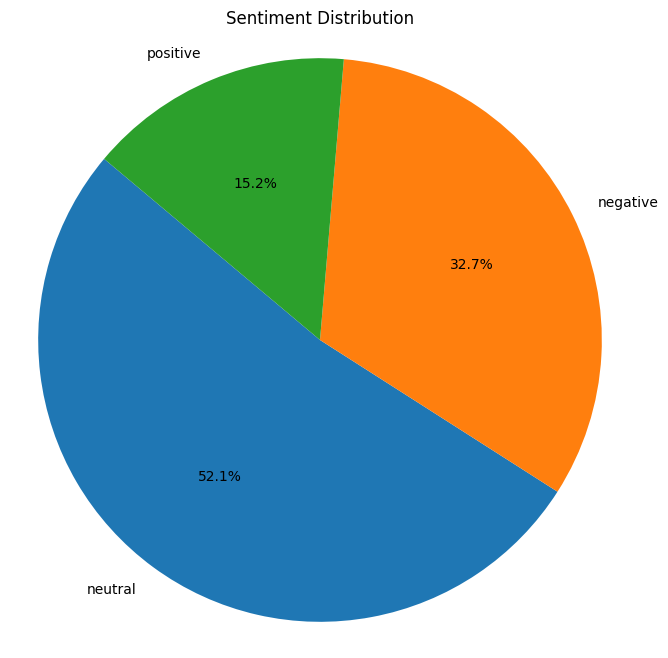

In [18]:
data['sentiment'].value_counts()

# Data
sentiment_counts = data['sentiment'].value_counts()

# Plotting
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [19]:
# Filter the DataFrame for positive sentiment
positive_tweets = data[data['sentiment'] == 'positive']

# Print all positive tweets
for index, row in positive_tweets.iterrows():
    print(row['translated_cleaned_text'])


Nice to see Eredivisie Many empty chairs near Groningen in recent years now year of KKD and the stadium is nice and full with us it also started to live more when we play a year lower and see where we are now and how the region lives Grocam FCTwente
We owe that the gas tap is now closing to the unbridled efforts of many very normal invisible people I see a lot of breasts while nothing had been achieved without these invaria because of these lovely people this you have achieved this together Groningen peplepower
A photo a day keeps My Freedom Close 21042024 Yesterday Photography Photo Photo Photography Photo Journalism stories Story Stories Personal Passion Passion Architecture Moma Aduard Westerkwartier Groningen
cant believe my daughter is 20 today happy to be in her university city of groningen celebrating 20 years of kate with my sister
fab day in groningen with my daughter sister cousin amp his son 1st amp 2nd cousins having the chats amp craic lots of family stories being told amp

In [20]:
# Filter the DataFrame for positive sentiment
positive_tweets = data[data['sentiment'] == 'negative']

# Print all positive tweets
for index, row in positive_tweets.iterrows():
    print(row['translated_cleaned_text'])

How do I explain this to my child fences for your flat everywhere cracks but have to explain to your child that you do not know if and when something will be done, the madness of Groningen should therefore be solved yesterday with the flame apartment this should solve this
Senator user on fire about arrogant attitude of user towards user about the Gaswinning Groningen of Rooijen is the only one who wants a rational approach and cannot be taken hostage by the emomafia in NL media amp politics that do everything based on emotion
History is going to judge very hard on this madness a historic error Groningen gas tap
Never throw your old shoes away before you have new Groningen Dom Concrete layer of 500 meters ensures that Groningen gas tap Inkt will never open again
It is really incomprehensible that Henk Kamp is still offered a platform and that on a day that the official closure of the gas tap has been ratified in Groningen where camp played a very debatable role on 1 Gas Council file le

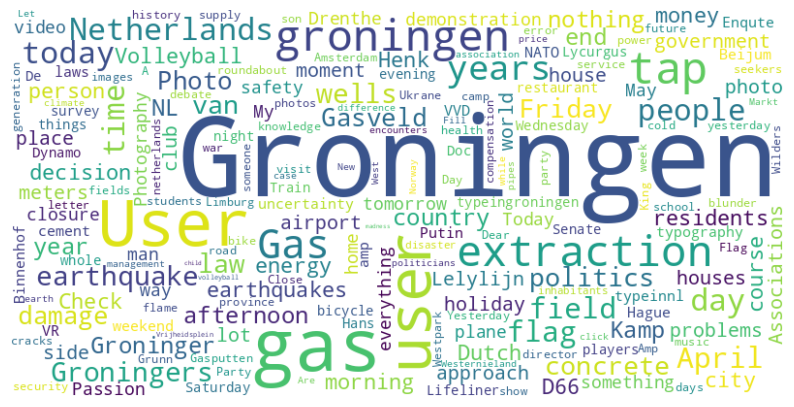

In [21]:
from textblob import TextBlob
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Create TextBlob objects for each preprocessed tweet
data['textblob'] = data['translated_cleaned_text'].apply(TextBlob)

# Extract nouns from each tweet and flatten the list
nouns = [word for blob in data['textblob'] for word, pos in blob.tags if pos.startswith('N')]

# Count occurrences of each noun
noun_counts = Counter(nouns)

# Visualize the results using a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(noun_counts)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Topic analysis

In [32]:
#Preprocessing for LDA

# Define stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Tokenization, stopwords removal, and lemmatization function
def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text)
    # Remove stopwords and lemmatize
    processed_tokens = [lemmatizer.lemmatize(token.lower()) for token in tokens if token.lower() not in stop_words]
    return processed_tokens

# Apply preprocessing to each document in the 'translated_cleaned_text' column
processed_texts = [preprocess_text(text) for text in data['translated_cleaned_text']]

# Create dictionary and corpus for LDA
dictionary = Dictionary(processed_texts)
corpus = [dictionary.doc2bow(text) for text in processed_texts]

# Train LDA model
lda_model = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=30)

# Print topics
for idx, topic in lda_model.print_topics():
    print(f'Topic: {idx} \nWords: {topic}\n')

Topic: 0 
Words: 0.066*"groningen" + 0.044*"user" + 0.018*"gas" + 0.015*"," + 0.010*"also" + 0.007*"flag" + 0.006*"tap" + 0.005*"association" + 0.005*"close" + 0.004*"extraction"

Topic: 1 
Words: 0.066*"groningen" + 0.021*"gas" + 0.015*"user" + 0.014*"," + 0.006*"extraction" + 0.006*"law" + 0.006*"still" + 0.004*"amp" + 0.004*"full" + 0.004*"also"

Topic: 2 
Words: 0.051*"groningen" + 0.032*"gas" + 0.018*"user" + 0.016*"," + 0.011*"tap" + 0.011*"year" + 0.009*"extraction" + 0.008*"close" + 0.008*"stupid" + 0.007*"field"

Topic: 3 
Words: 0.046*"groningen" + 0.021*"user" + 0.014*"," + 0.011*"gas" + 0.010*"photo" + 0.008*"volleyball" + 0.006*"new" + 0.005*"story" + 0.005*"never" + 0.004*"."

Topic: 4 
Words: 0.032*"groningen" + 0.031*"user" + 0.009*"," + 0.007*"well" + 0.006*"gas" + 0.006*"really" + 0.004*"bicycle" + 0.004*"would" + 0.004*"han" + 0.003*"n"



In [33]:
# Create pyLDAvis visualization
vis_data = gensimvis.prepare(lda_model, corpus, dictionary)
vis_data

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.024912  0.107073       1        1  26.677585
1      0.043711 -0.072209       2        1  25.549234
2      0.087243 -0.023603       3        1  21.803602
3     -0.113621 -0.029035       4        1  17.927175
4     -0.042244  0.017775       5        1   8.042404, topic_info=            Term        Freq       Total Category  logprob  loglift
42          user  124.000000  124.000000  Default  30.0000  30.0000
1131  volleyball    7.000000    7.000000  Default  29.0000  29.0000
175        photo   12.000000   12.000000  Default  28.0000  28.0000
65          year   18.000000   18.000000  Default  27.0000  27.0000
709       stupid   12.000000   12.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
275         good    1.151078    8.297248   Topic5  -5.8171   0.5452
373          end    1.152318    9.141218   Topic5  -5.8160   0.4494
161       people    1.152849   11.371783   Topic5  -5.8156   0.2315
15          know    1.152312   10.536781   Topic5  -5.8160   0.3073
65          year    1.151533   18.683622   Topic5  -5.8167  -0.2661

[339 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
5         1  0.277605     ,
5         2  0.262994     ,
5         3  0.233772     ,
5         4  0.175329     ,
5         5  0.058443     ,
...     ...       ...   ...
65        1  0.160568  year
65        2  0.160568  year
65        3  0.588751  year
65        5  0.053523  year
1061      4  0.961107  zuid

[510 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5])